<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>CIFAR 10 Advanced</center></b>
</div>

# Configure Learning Environment

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image
from tqdm import trange
import os
from datetime import datetime

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
STYLE_LOSS_WEIGHT = 1e-5
CONTENT_IMG_PATH = os.path.join("datas", "style", "City.jpg")
STYLE_IMG_PATH = os.path.join("datas", "style", "StarryNight.jpg")
IMG_SIZE = 400
OUTPUT_DIR_PATH = os.path.join("datas")

In [5]:
model = models.vgg19_bn(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [6]:
model = nn.Sequential(*list(model.features.children())[:52]).to(device)
for param in model.parameters():
    param.require_grad = False

In [7]:
content_img = Image.open(CONTENT_IMG_PATH)
style_img = Image.open(STYLE_IMG_PATH)

In [8]:
T = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
iT = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

In [10]:
content_tensor = T(content_img).unsqueeze(0)
style_tensor = T(style_img).unsqueeze(0)

In [11]:
class Extractor(nn.Module):
    fetures = None
    
    def __init__(self, layer):
        super().__init__()
        self.hook = layer.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def close(self):
        self.hook.remove()

In [12]:
# Extract features from content image
content_exts = [Extractor(model[i]) for i in [45]]
model(content_tensor.to(device))
content_features = [ext.features.clone() for ext in content_exts]

In [13]:
# Extract features from style image
style_exts = [Extractor(model[i]) for i in [2, 9, 16, 29, 42]]
model(style_tensor.to(device))
style_features = [ext.features.clone() for ext in style_exts]

In [15]:
input_tensor = content_tensor.clone().requires_grad_()
# input_tensor = torch.randn(content_tensor.shape, requires_grad=True)

In [16]:
optimizer = torch.optim.SGD([input_tensor], lr=100.)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)

In [17]:
def content_loss(y, y_hat):
    loss = 0
    for i in range(len(y_hat)):
        loss += F.mse_loss(y[i], y_hat[i])
    return loss / len(y_hat)

In [18]:
def gram_matrix(x):
    b, c, h, w = x.size()
    x = x.view(b * c, -1)
    return torch.mm(x, x.t())

In [19]:
def style_loss(y, y_hat):
    loss = 0
    for i in range(len(y_hat)):
        y_gram = gram_matrix(y[i])
        y_hat_gram = gram_matrix(y_hat[i])
        loss += F.mse_loss(y_gram, y_hat_gram)
    return loss / len(y_hat)

In [27]:
pbar = trange(10000+1)
for i in pbar:
    model(input_tensor.to(device))
    
    current_content_features = [ext.features.clone() for ext in content_exts]
    current_style_features = [ext.features.clone() for ext in style_exts]
    
    c_loss = content_loss(content_features, current_content_features)
    s_loss = style_loss(style_features, current_style_features) * STYLE_LOSS_WEIGHT
    loss = c_loss + s_loss
    pbar.set_description("Content loss %.6f Style loss %.6f" % (c_loss, s_loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 500 == 0:
        output_img = iT(input_tensor).detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1).numpy() * 255 
        Image.fromarray(output_img.astype("uint8")).save(os.path.join(OUTPUT_DIR_PATH, "%s.png" % i))
        scheduler.step()

Content loss 0.000000 Style loss 2.272091:   0%|          | 0/10001 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'datas/20220218_121457/0.png'

# Prepare Data

In [4]:
# !git clone https://github.com/jaddoescad/ants_and_bees
# !mv ants_and_bees/* datas
# !rm -rf ants_and_bees

In [5]:
augumentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])
res_train = datasets.ImageFolder("./datas/train", transform=augumentation)
res_valid = datasets.ImageFolder("./datas/val", transform=transform)

In [9]:
len(res_train), len(res_valid)

(244, 153)

In [10]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=20, shuffle=True)
load_valid = torch.utils.data.DataLoader(res_valid, batch_size=20, shuffle=True)

In [11]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20]))

In [12]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

In [13]:
class_names = ["ant", "bee"]

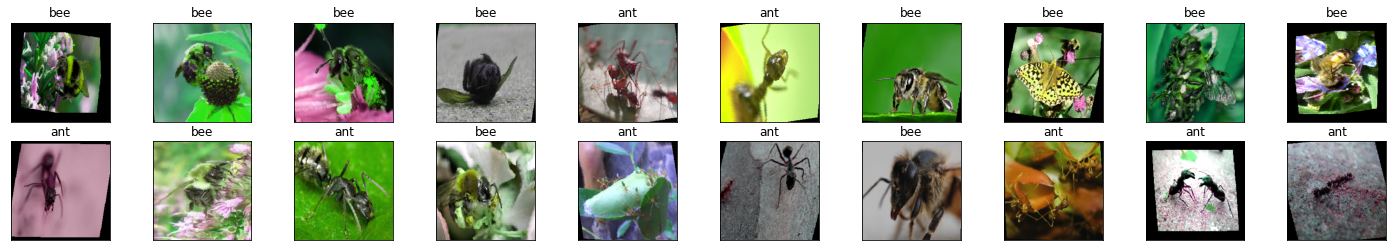

In [15]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_names[labels[idx].item()])

# Generate Model

In [16]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
last_input = model.classifier[6].in_features
model.classifier[6] = nn.Linear(last_input, len(class_names))
model.to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [23]:
epochs = 10
size_bunch_train = len(load_train)
size_bunch_valid = len(load_valid)

In [24]:
history = []
for epoch in range(epochs):
    loss_learns, accu_learns, loss_valids, accu_valids = .0, .0, .0, .0

    # Learning Step
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        # Caculating loss/accuracy for monitoring
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    # Validating Step
    for datas, labels in load_valid:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # Caculating loss/accuracy for monitoring
        loss_valids += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_valids += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    loss_learn = loss_learns / size_bunch_train
    accu_learn = accu_learns / size_bunch_train
    loss_valid = loss_valids / size_bunch_valid
    accu_valid = accu_valids / size_bunch_valid
    history.append({"loss": loss_learn, "accuracy": accu_learn, "validation loss": loss_valid, "validation accuracy": accu_valid})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %, validation loss: {loss_valid:.4f}, validation accuracy: {accu_valid:.2f} %")

01 step -> loss: 0.6230, accuracy: 64.23 %, validation loss: 0.4811, validation accuracy: 80.87 %
02 step -> loss: 0.3829, accuracy: 82.31 %, validation loss: 0.4101, validation accuracy: 83.99 %
03 step -> loss: 0.3731, accuracy: 83.85 %, validation loss: 0.4410, validation accuracy: 81.54 %
04 step -> loss: 0.3138, accuracy: 85.38 %, validation loss: 0.3973, validation accuracy: 83.08 %
05 step -> loss: 0.2237, accuracy: 92.69 %, validation loss: 0.3090, validation accuracy: 87.45 %
06 step -> loss: 0.2032, accuracy: 91.15 %, validation loss: 0.3258, validation accuracy: 87.45 %
07 step -> loss: 0.2154, accuracy: 90.77 %, validation loss: 0.4156, validation accuracy: 82.74 %
08 step -> loss: 0.1629, accuracy: 93.08 %, validation loss: 0.3883, validation accuracy: 84.62 %
09 step -> loss: 0.1341, accuracy: 93.46 %, validation loss: 0.3356, validation accuracy: 85.91 %
10 step -> loss: 0.1168, accuracy: 96.92 %, validation loss: 0.3569, validation accuracy: 84.33 %


In [25]:
df_history = pd.DataFrame.from_records(history)

<AxesSubplot:>

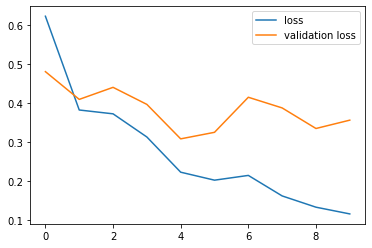

In [26]:
df_history[["loss", "validation loss"]].plot()

<AxesSubplot:>

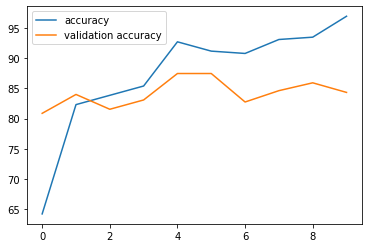

In [27]:
df_history[["accuracy", "validation accuracy"]].plot()

# Prediction

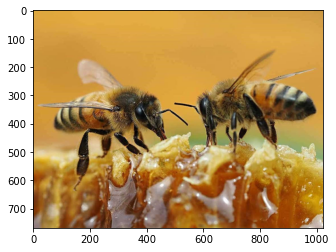

In [33]:
url = "https://www.beeculture.com/wp-content/uploads/2020/05/Buzz-1-2.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

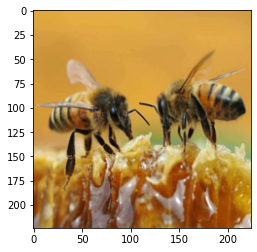

In [34]:
img_pred = transform(img)
plt.imshow(im_convert(img_pred))

In [35]:
img_input = img_pred.to(device).unsqueeze(0)
pred = model(img_input)
_, pred_label = torch.max(pred, 1)
class_names[pred_label.item()]

'bee'